## Section 1: Background
This dataset comes from the Cleveland Clinic's heart disease database and consists of 13 predictor features and an outcome variable for 303 patient records. It was downloaded from Kaggle on April 15, 2019 from the following url: https://www.kaggle.com/ronitf/heart-disease-uci.

The features are as follows:
1. *age:* Age in years
1. *sex:* Renamed "male", 1 = male; 0 = female
1. *cp:* Chest pain type
1. *trestbps:* Resting blood pressure (in mm Hg on admission to the hospital)
1. *chol:* Serum cholestoral in mg/dl
1. *fbs:* Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
1. *restecg:* Resting electrocardiographic results
1. *thalach:* Maximum heart rate achieved
1. *exang:* Exercise induced angina (1 = yes; 0 = no)
1. *oldpeak:* ST depression induced by exercise relative to rest
1. *slope:* The slope of the peak exercise ST segment
1. *ca:* Number of major vessels colored by flourosopy (0-3)
1. *thal:* 3 = normal; 6 = fixed defect; 7 = reversable defect
1. *target:* Presence of heart disease (heart disease=1, no heart disease=0)

In [125]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest as kbest
from sklearn.feature_selection import chi2
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [126]:
path = 'H:/Documents/Training/Thinkful'
file = 'uci_heart.csv'

In [127]:
# Reading data and initial cleaning
d = pd.read_csv(path+'/'+file)

# Reset index to preserve values explicitly
d = d.reset_index()

# Change names of 'sex' to 'male' and newly created 'index' field to 'index_org' for clarity
d.columns = pd.Series(d.columns).replace({'index': 'index_org', 'sex': 'male'})

In [128]:
print("Rows: {}".format(len(d.index)))
print("Columns: {}".format(len(d.columns)))

Rows: 303
Columns: 15


In [129]:
# Creating metadata table to keep track of variable definitions and types
md = pd.DataFrame(index=['age', 'male', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'])
md['decode'] = ['Age in years', '1 = male; 0 = female', 'Chest pain type', 'Resting blood pressure (in mm Hg on admission to the hospital)', 'Serum cholestoral in mg/dl', 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)', 'Resting electrocardiographic results', 'Maximum heart rate achieved', 'Exercise induced angina (1 = yes; 0 = no)', 'ST depression induced by exercise relative to rest', 'The slope of the peak exercise ST segment', 'Number of major vessels colored by flourosopy (0-3)', '3 = normal; 6 = fixed defect; 7 = reversable defect', 'Presence of heart disease (heart disease=1, no heart disease=0)']

# Identifying categorical variables by looking at the number of unique values per variable
dist = d.apply(lambda x: len(x.drop_duplicates()))
cat = pd.DataFrame(dist, columns=['levels'])
cat.loc[cat.levels==2, 'var_type'] = 'dummy'
cat.loc[(cat.levels>2) & (cat.levels<10), 'var_type'] = 'categorical'

# Adding variable type data to metadata table, and clarifying "target" as an outcome variable
md = pd.concat([md, cat], axis=1, sort=False)
md.loc[md.var_type.isna(), 'var_type'] = 'ratio'
md.loc['target', 'var_type'] = 'outcome'

In [130]:
# # Check for null values
# d.apply(lambda x: sum(x.isna()))
md


,decode,levels,var_type
age,Age in years,41,ratio
male,1 = male; 0 = female,2,dummy
cp,Chest pain type,4,categorical
trestbps,Resting blood pressure (in mm Hg on admission ...,49,ratio
chol,Serum cholestoral in mg/dl,152,ratio
fbs,Fasting blood sugar > 120 mg/dl (1 = true; 0 =...,2,dummy
restecg,Resting electrocardiographic results,3,categorical
thalach,Maximum heart rate achieved,91,ratio
exang,Exercise induced angina (1 = yes; 0 = no),2,dummy
oldpeak,ST depression induced by exercise relative to ...,40,ratio


### Investigating relationships between continuous relationships with scatter plots

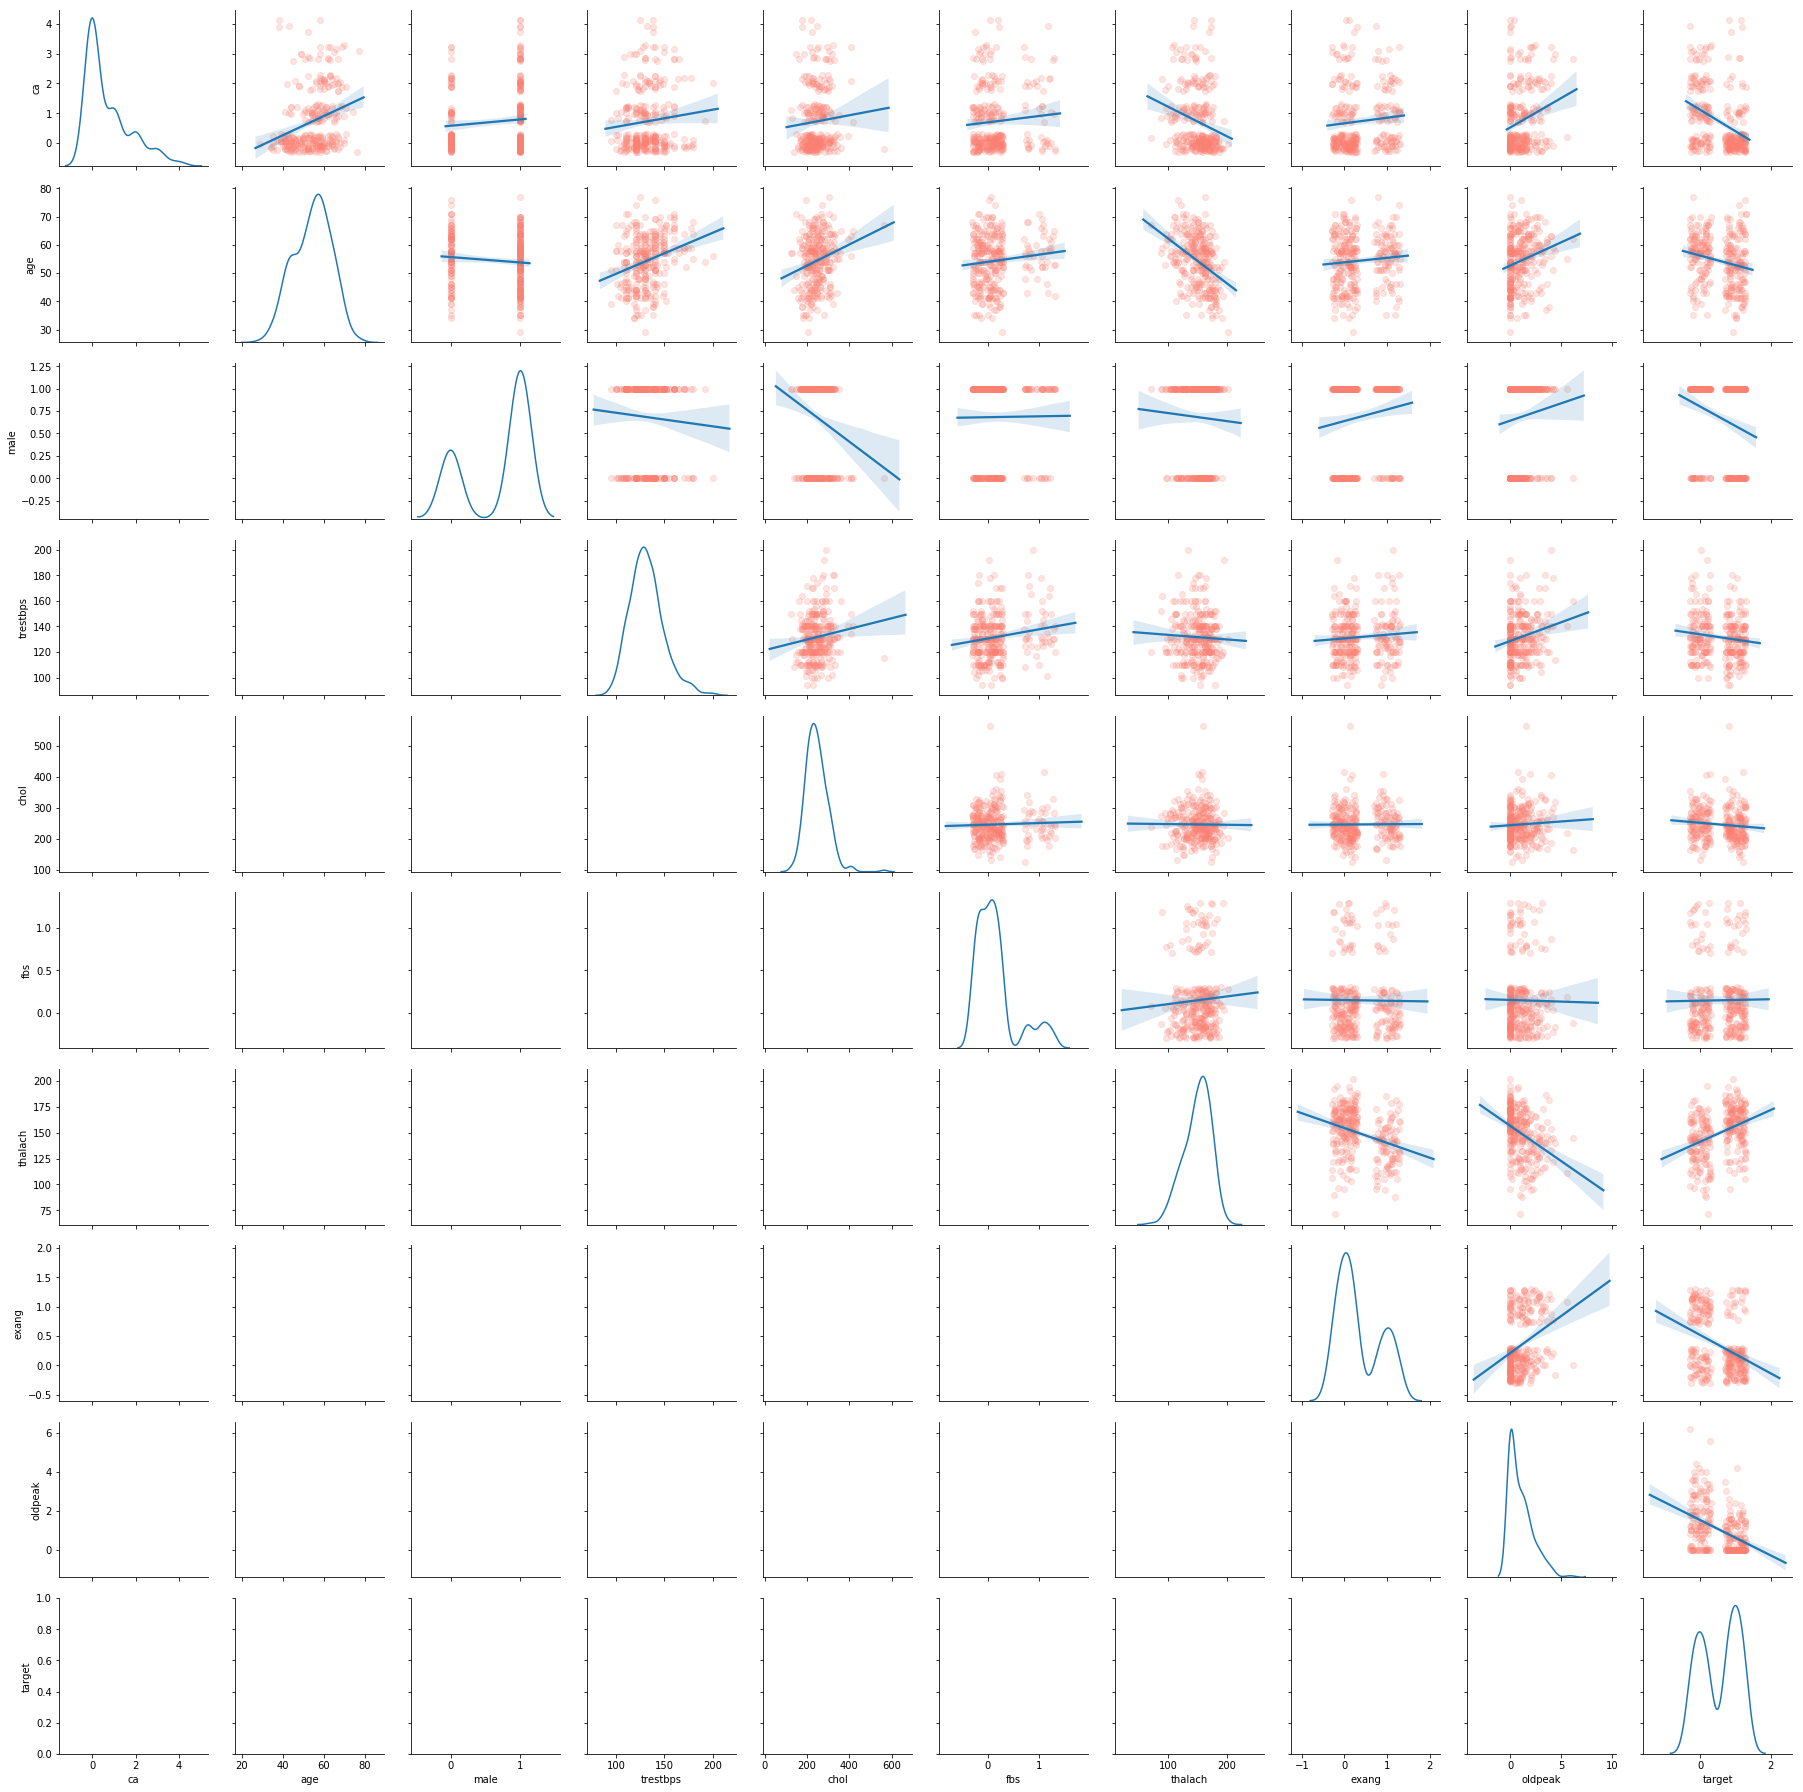

In [131]:
pair = d.loc[:, ['index_org', 'ca']+list(pd.Series(md.loc[md.var_type != 'categorical'].index))]

jit_fld = ['ca', 'fbs', 'exang', 'target']
jitter = pd.DataFrame(np.random.uniform(-.3, .3, size=(pair[jit_fld].shape)),
                      columns=jit_fld)

pair.loc[:, jit_fld] = pair.loc[:, jit_fld] + jitter

g = sns.PairGrid(pair.drop(columns = 'index_org'), diag_sharey=False)
g.map_upper(sns.regplot, scatter_kws=dict(alpha=0.2, color='salmon'))
g.map_diag(sns.kdeplot)
plt.show()

### Heatmap of Pearson correlation values
The colors on the heat map correspond to the absolute value of the Pearson coefficient. Therefore, blue signifies no relationship and pink/red signify larger magnitude of the coefficient.

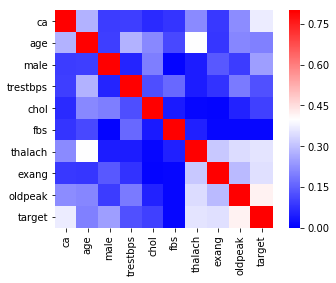

                ca       age      male  trestbps      chol       fbs  \
ca        1.000000  0.280729  0.096101  0.096931  0.066947  0.081909   
age       0.280729  1.000000 -0.098447  0.279351  0.213678  0.112631   
male      0.096101 -0.098447  1.000000 -0.056769 -0.197912  0.008428   
trestbps  0.096931  0.279351 -0.056769  1.000000  0.123174  0.163779   
chol      0.066947  0.213678 -0.197912  0.123174  1.000000  0.040852   
fbs       0.081909  0.112631  0.008428  0.163779  0.040852  1.000000   
thalach  -0.217701 -0.398522 -0.044020 -0.046698 -0.009940  0.051920   
exang     0.090164  0.086867  0.138230  0.080918  0.008717 -0.010395   
oldpeak   0.219661  0.210013  0.096093  0.193216  0.053952 -0.011403   
target   -0.370962 -0.200369 -0.249084 -0.125354 -0.101733  0.011564   

           thalach     exang   oldpeak    target  
ca       -0.217701  0.090164  0.219661 -0.370962  
age      -0.398522  0.086867  0.210013 -0.200369  
male     -0.044020  0.138230  0.096093 -0.249084  
tre

In [132]:
d_corr = pair.drop('index_org', axis=1).corr()
d_corr_abs = d_corr.abs()

sns.heatmap(d_corr_abs, square=True, vmax=0.8, vmin=0, cmap='bwr')
plt.show()

print(d_corr)

### Filtering out poorly correlated features
As we can see, cholesterol and fasting blood sugar > 120 have a pearson coefficient of close to 0 with the target outcome. Therefore I will be dropping these variables from my models.

In [223]:
feate = ['male', 'trestbps', 'restecg', 'oldpeak', 'ca', 'thal']
eng = d.loc[:, feate].copy()

## New Features
### Continuous variables
1. *age_sqrt:* The square root of age
1. *chol_exp3:* The value of serum cholesterol, cubed
1. *thalach_ln:* The natural log of the maximum heart rate achieved
1. *trestbps_e:* e raised to the value of the patient's resting blood pressure at admission
1. *chol_invs:* 1/(serum cholesterol, mg/dl)

These transformations exacerbate difference in scale between variables. For example, chol_invs values now fall between 0 and 1, whereas trestbps_e is on the scale of 1 X 10^52.

### Categorical variables
6. *Slope:* One-way ANOVA
1. *Thal:* PCA (1)
1. *Chest pain type:* K best features (2)

### Combinations
9. *age_thalach:* We previously saw that the highest correlation between continuous variables was between age and maximum heart rate achieved (*thalach*). Therefore, this new variable is an average of the normalized age and normalized heart rate. Maximum heart rate is reported on a scale almost 2x the scale of age.
1. *exang65:* Patient is over 65 and experienced exercise-induced angina

### Code: Transformations
#### Continuous variables

In [224]:
# Transforming continuous variables
eng['age_sqrt'] = np.sqrt(d.age)
eng['chol_exp3'] = d.chol^3
eng['thalach_ln'] = np.log(d.thalach)
eng['trestbps_e'] = np.exp(d.trestbps)
eng['chol_invs'] = d.chol.apply(lambda x: 1/x)

In [225]:
feate = list(eng.columns.values)
sorted(feate)

['age_sqrt',
 'ca',
 'chol_exp3',
 'chol_invs',
 'male',
 'oldpeak',
 'restecg',
 'thal',
 'thalach_ln',
 'trestbps',
 'trestbps_e']

#### Categorical variables with more than 2 levels

In [226]:
# Transforming 
# Creating dummy variables
dum = pd.get_dummies(d, columns=md.loc[md.var_type=='categorical'].index)
dum.shape

(303, 34)

##### Select K best for type of chest pain

In [262]:
def check_concat(mydf, mycol):
    try:
        if type(mycol)==str:
            mycol = pd.Series(mycol)
#             print(1)
        if sum(mydf.columns.isin(mycol))>0:
#             print(2)
            temp = mydf.copy()
            result = temp.drop(mycol, axis=1)
        else:
            result = mydf.copy()
#             print(3)
            
        return(result)
    except Exception as e:
        print(e)
        return(mydf.copy())

In [259]:
def check_append(myset, myval):
    try:
        test = list(filter(lambda x: x==myval, myset))
        if len(test)==0:
            if type(myset) == pd.core.series.Series:
                result = myset.append(pd.Series(myval))
            elif type(myset) == list:
                myset.append(myval)
                result = myset
            elif type(myset) == np.ndarray:
                result = np.append(myset, myval)
            
        else:
            result = myset
        
        return(result)
    
    except Exception as e:
        print(e)
        return(False)

In [261]:
# Step 1: separate predictors from target
cp_cols = pd.Series(dum.columns).str.extract(r'^(cp.*)', expand=False).dropna()
cp = dum[cp_cols]
t = dum.target

# Step 2: Create the empty model
cp_m = kbest(chi2, k=2)

# Step 3: Fit and transform (in this case in one step)
# Something important to remember is that kbest.fit_transform returns an array,
# not a dataframe. Consequently, the penultimate step is converting to a DF.
new_col = ['cp_k1', 'cp_k2']
cp_a = cp_m.fit_transform(cp, t)
cp_new = pd.DataFrame(cp_a, columns=new_col)

# Step 4: Join back to the output dataset
# dum = pd.concat([dum, cp_new], sort=False, axis=1)
eng = check_concat(eng, new_col)

eng = pd.concat([eng, cp_new], axis=1, sort=False)
print(sum(eng.columns.isin(new_col)))

3
2


In [220]:
feate_cat = new_col

##### PCA for thal

In [263]:
thal4 = dum[list(dum.columns.str.extract(r'(thal_.*)', expand=False).dropna())]

# print(dum.shape)
# print(thal4.shape)
# print(thal4.dropna().shape)

pca = PCA(n_components=1)
pc_out = pca.fit_transform(thal4)
pc_df = pd.DataFrame(pc_out, columns=['thal_pca'])

eng = check_concat(eng, 'thal_pca')
eng = pd.concat([eng, pc_df], axis=1, sort=False)

print(sum(eng.columns.isin(['thal_pca'])))

1


In [264]:
feate_cat = check_append(feate_cat, 'thal_pca')
feate_cat

['cp_k1', 'cp_k2', 'thal_pca']

##### Chi-square analysis, slope

In [265]:
slope_ct = pd.crosstab(index=dum.slope_0, columns=dum.target)
sl0 = stats.chi2_contingency(slope_ct, correction=False)
sl1 = stats.chi2_contingency(pd.crosstab(index=dum.slope_1, columns=dum.target), correction=False)
sl2 = stats.chi2_contingency(pd.crosstab(index=dum.slope_2, columns=dum.target), correction=False)

# print(sl0[1])
# print(sl1[1])
# print(sl2[1])
new_fld = 'slope_chi2'
eng.loc[:, new_fld] = dum.slope_2
print(sum(eng.columns.isin([new_fld])))

1


In [266]:
feate_cat = check_append(feate_cat, new_fld)

#### Combination variables
###### Averaging normalized age and maximum heart rate achieved

In [268]:
new_fld = 'age_thalach'
norm = pd.DataFrame(columns=['age_norm', 'thalach_norm', new_fld])
age_norm = dum.age/dum.age.max()
norm.loc[:, 'age_norm'] = age_norm - np.mean(age_norm)

thalach_norm = dum.thalach/dum.thalach.max()
thalach_norm = 1 - thalach_norm
norm.loc[:, 'thalach_norm'] = thalach_norm - np.mean(thalach_norm)

norm.loc[:, new_fld] = norm.apply(np.mean, axis=1)

eng = check_concat(eng, new_fld)
eng.loc[:, new_fld] = norm[new_fld]

print(sum(eng.columns.isin([new_fld])))

1


##### Over 65 and exercise induced angina

In [269]:
new_fld = 'over65'
dum.loc[dum.age >= 65, new_fld] = 1
dum.loc[dum.age < 65, new_fld] = 0

eng = check_concat(eng, new_fld)
eng.loc[:, new_fld] = dum.over65*dum.exang

print(sum(eng.columns.isin([new_fld])))

1


In [271]:
feate_cat = check_append(feate_cat, new_fld)
feate_cat

['cp_k1', 'cp_k2', 'thal_pca', 'slope_chi2', 'over65']